In [15]:
import os
import numpy as np
from PIL import Image
from pathlib import Path
from torchvision.transforms.v2 import Resize
from torchvision.transforms.v2.functional import to_pil_image

from anomalib import TaskType
import torch

seed = 67
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
# torch.backends.cudnn.benchmark = True
# torch.backends.cudnn.enabled = True
torch.set_float32_matmul_precision('medium')


class ExtractBChannel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # 可以在这里设置一些参数（如果需要的话），例如大小，填充值等
        pass
    
    # RGB (N, 3, H, W) 的tensor类型
    def forward(self, img):
        
        tmp_img = img.clone()
        if len(img.shape) == 3: tmp_img = tmp_img.unsqueeze(0)
        bs, channels, height, width = tmp_img.shape
        
        if channels == 1: tmp_img = tmp_img.repeat(1,3,1,1)
        
        b_channel = tmp_img[:, 2, :, :]     # 提取 B 通道（张量的第三个通道，索引为2）
        b_channel[b_channel < 100/255] = 0
        # b_channel[b_channel >= 100/255] = 1    # 不能添加
        b_channel_3 = b_channel.repeat(1, 3, 1, 1)
        
        out_img = b_channel_3
        if len(img.shape) == 3: out_img = out_img.squeeze(0)
        
        #print("{} --> {} --> {} -- {};".format(img.shape, tmp_img.shape, b_channel.shape, out_img.shape))
        return out_img

In [16]:
from lightning.pytorch.callbacks import EarlyStopping
from anomalib.callbacks.checkpoint import ModelCheckpoint
from anomalib.callbacks import GraphLogger
from anomalib.loggers import AnomalibMLFlowLogger
from torchvision.transforms.v2 import Resize, RandomHorizontalFlip, Compose, Normalize, ToDtype,RandomAffine,RandomPerspective, Grayscale, ToTensor, Transform, GaussianBlur
from anomalib.data.image.folder import Folder, FolderDataset

import warnings
warnings.filterwarnings("ignore")




# read_image,会自动将数据类型转换为float32,但不会进行255归一化
train_transform = Compose(
    [
        ExtractBChannel(),          # 0~1之间
        # ToTensor(),
        #ToDtype(torch.uint8, scale=True),
        Resize((256, 256)),                # 如果resize的HW不一致，会引起fastflow模型报layernorm错误
        # RandomHorizontalFlip(p=0.3),       # 无seed, 0.90 --> 0.95
        #RandomAffine(degrees=(-5, 5), translate=(0.95, 0.95),scale=(0.95, 0.95), ),  # onnx 不支持 grid_sampler.
        RandomPerspective(distortion_scale=0.1, p=0.3),
        #ToDtype(torch.float32, scale=True),  # Normalize expects float input
        Normalize(mean=[0.406, 0.406, 0.406], std=[0.225, 0.225, 0.225]),
    ],
)

eval_transform = Compose(
    [
        ExtractBChannel(),          # 0~1之间
        # ToTensor(),
        #ToDtype(torch.uint8, scale=True),
        Resize((256, 256)),
        #RandomHorizontalFlip(p=0.3),   # 无seed, 0.90 --> 0.95
        #RandomAffine(degrees=(-5, 5), translate=(0.95, 0.95),scale=(0.95, 0.95), ),  # onnx 不支持 grid_sampler.
        #RandomPerspective(distortion_scale=0.1, p=0.3),
        #ToDtype(torch.float32, scale=True),  # Normalize expects float input
        Normalize(mean=[0.406, 0.406, 0.406], std=[0.225, 0.225, 0.225]),
    ],
)


In [17]:
def draw_pic(inferencer, png_files, input_path, outpath):
    from anomalib.data.utils import read_image
    import time
    import matplotlib.pyplot as plt


    for file_name in png_files:
            
        image = read_image(path=os.path.join(input_path, file_name))                     # HWC
        CHW_image = read_image(path=os.path.join(input_path, file_name),as_tensor=True)  # CHW
        

        # 记录开始时间
        start_time = time.time()
        predictions = inferencer.predict(image=image)
        filter_image = ExtractBChannel()(CHW_image)  # CHW -> CHW
        filter_image = filter_image.permute(1,2,0)    # CHW -> HWC
        
        train_image = train_transform(CHW_image)  # CHW -> CHW
        train_image = train_image.permute(1,2,0)    # CHW -> HWC
        
        print("image: {}; filter_image: {}; train_image: {}; predictions.heat_map: {};".format(image.shape, filter_image.shape, train_image.shape, predictions.heat_map.shape))
        
        
        # 记录结束时间
        end_time = time.time()

        # 计算耗时
        elapsed_time = end_time - start_time
        print(f"Prediction took {elapsed_time:.4f} seconds.")
        print(predictions.pred_score, predictions.pred_label)
        # 创建一个新的图形窗口
        fig, axs = plt.subplots(1, 5, figsize=(18, 6))  # 创建一个1行3列的子图网格

        # 原始图像
        axs[0].imshow(image)
        axs[0].set_title('Original Image')
        axs[0].axis('off')  # 关闭坐标轴
        
        # 训练用图像
        axs[1].imshow(filter_image.numpy())
        axs[1].set_title('Filter Image')
        axs[1].axis('off')  # 关闭坐标轴
        
        # 训练用图像
        axs[2].imshow(train_image.numpy())
        axs[2].set_title('Train Image')
        axs[2].axis('off')  # 关闭坐标轴

        # 热图
        axs[3].imshow(predictions.heat_map, cmap='hot', interpolation='nearest')
        axs[3].set_title('Heat Map')
        axs[3].axis('off')  # 关闭坐标轴

        # 预测掩模
        axs[4].imshow(predictions.pred_mask, cmap='gray', interpolation='nearest')
        axs[4].set_title('Predicted Mask')
        axs[4].axis('off')  # 关闭坐标轴


        # 添加文本信息到图形的上方中间位置
        fig_text_x = 0.1  # x坐标在图形宽度的中心位置
        fig_text_y = 0.95  # y坐标稍微靠近图形的顶部，避免与子图重叠
        fig.text(fig_text_x, fig_text_y,
                f'Prediction Time: {elapsed_time:.4f} s\n'
                f'Predicted Class: {predictions.pred_label}\n'
                # f'Score: {predictions.pred_score:.4f}\n'
                f'Threshold: {predictions.pred_score:.4f}' if hasattr(predictions, 'pred_score') else '',
                ha='left', va='center', fontsize=12,
                bbox=dict(boxstyle="round", fc="w", ec="0.5", alpha=0.5))  

        # 显示整个图形
        plt.tight_layout()  # 调整子图间的间距
        #plt.show()
        plt.savefig(os.path.join(outpath, file_name))
        plt.close()
        
    print("Done")

In [18]:
import matplotlib.pyplot as plt
import torch
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


def pplot(imgs, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            boxes = None
            masks = None
            if isinstance(img, tuple):
                img, target = img
                if isinstance(target, dict):
                    boxes = target.get("boxes")
                    masks = target.get("masks")
                elif isinstance(target, tv_tensors.BoundingBoxes):
                    boxes = target
                else:
                    raise ValueError(f"Unexpected target type: {type(target)}")
            img = F.to_image(img)
            if img.dtype.is_floating_point and img.min() < 0:
                # Poor man's re-normalization for the colors to be OK-ish. This
                # is useful for images coming out of Normalize()
                img -= img.min()
                img /= img.max()

            img = F.to_dtype(img, torch.uint8, scale=True)
            if boxes is not None:
                img = draw_bounding_boxes(img, boxes, colors="yellow", width=3)
            if masks is not None:
                img = draw_segmentation_masks(img, masks.to(torch.bool), colors=["green"] * masks.shape[0], alpha=.65)

            ax = axs[row_idx, col_idx]
            ax.imshow(img.permute(1, 2, 0).numpy(), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

## 参数配置

In [19]:
configs = {
    "dataset_root": r"F:\Projects\anomalib\notebooks\datasets\3-5 - jing",
    "outputs_path": r"F:\Projects\anomalib\notebooks\datasets\3-5 - jing\outputs",
    "model_name": "Uflow",
}

dataset_root = configs["dataset_root"]
print("dataset_root: {}".format(dataset_root))

normal_folder_path = os.path.join(configs["dataset_root"], "normal")
abnormal_folder_path = os.path.join(configs["dataset_root"], "abnormal")

normal_ouput_path = os.path.join(configs["outputs_path"], configs["model_name"] , "normal_outputs")
abnormal_output_path = os.path.join(configs["outputs_path"], configs["model_name"] , "abnormal_outputs")

dataset_root: F:\Projects\anomalib\notebooks\datasets\3-5 - jing


## Custom 数据集配置

In [20]:



folder_datamodule = Folder(
    name="3-5",
    root=dataset_root,
    normal_dir="normal", abnormal_dir="abnormal",
    task=TaskType.CLASSIFICATION,
    num_workers=0,          # in jupyter, need to be zero. and can be non-0 in python main.py;
    # image_size=(256, 256),
    train_batch_size = 16, eval_batch_size = 8,                     # 计算的时候会使用cuda，因此需要限制BS不适用默认值32；
    train_transform=train_transform, eval_transform=eval_transform,
    seed = seed,
)

folder_datamodule.setup()            #! 进行数据集分割

INFO:anomalib.data.base.datamodule:No normal test images found. Sampling from training set using a split ratio of 0.20


==> 检查训练集、验证集、测试集的数据量

In [21]:
# Train images
i, data = next(enumerate(folder_datamodule.train_dataloader()))
print(data.keys(), data["image"].shape)

dict_keys(['image_path', 'label', 'image']) torch.Size([16, 3, 256, 256])


In [22]:
# # Train images
# i, data = next(enumerate(folder_datamodule.val_dataloader()))
# print(data.keys(), data["image"].shape)

In [23]:
# # Test images
# i, data = next(enumerate(folder_datamodule.test_dataloader()))
# print(data.keys(), data["image"].shape)

==> 查看图像内容

In [24]:
# img = to_pil_image(data["image"][0].clone())
# Image.fromarray((np.array(img)))

In [25]:
from anomalib.data.utils import read_image
test_image = read_image(r"F:\Projects\anomalib\notebooks\datasets\3-5\normal\1__DA2951175 (2).png", as_tensor=True)
print("处理前的数据: ",test_image.min(), test_image.max(), test_image.mean())

for trans in train_transform.transforms:
    tmp_image = trans(test_image)
    print(tmp_image.min(), tmp_image.max(), tmp_image.mean())

处理前的数据:  tensor(0.) tensor(0.9725) tensor(0.0655)
tensor(0.) tensor(0.9725) tensor(0.0457)
tensor(0.) tensor(0.9363) tensor(0.0655)
tensor(0.) tensor(0.9725) tensor(0.0655)
tensor(-1.8044) tensor(2.5180) tensor(-1.5135)


torch.Size([16, 3, 256, 256])
tensor(-1.8044) tensor(1.6324)
tensor(-1.8044) tensor(1.9547)
tensor(-1.8044) tensor(2.4231)
tensor(-1.8044) tensor(2.4718)
tensor(-1.8044) tensor(2.3566)
tensor(-1.8044) tensor(2.2869)
tensor(-1.8044) tensor(1.7699)
tensor(-1.8044) tensor(2.3566)
tensor(-1.8044) tensor(2.2537)
tensor(-1.8044) tensor(2.1463)
tensor(-1.8044) tensor(2.4537)
tensor(-1.8044) tensor(1.7691)
tensor(-1.8044) tensor(2.0553)
tensor(-1.8044) tensor(2.0797)
tensor(-1.8044) tensor(1.6885)
tensor(-1.8044) tensor(2.0792)


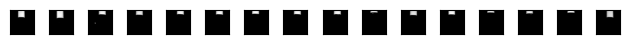

In [26]:
total_images = []
print(data["image"].shape)
for i in range(data["image"].shape[0]):
    test_img = data["image"][i]
    total_images.append(test_img)
    print(test_img.min(), test_img.max())

pplot(total_images)

## 模型选择和优化器配置

In [28]:
from anomalib.engine import Engine
from anomalib.models import Padim, Patchcore, Stfpm, Fastflow, Uflow


model_checkpoint = ModelCheckpoint(mode="max", monitor="image_F1Score")
early_stopping = EarlyStopping(monitor="image_F1Score", mode="max", patience=5)

graph_logger = GraphLogger()
callbacks = [
    model_checkpoint,
    #early_stopping,
    graph_logger,
]




if configs["model_name"] == "Patchcore":
    model = Patchcore()
    engine = Engine(task=TaskType.CLASSIFICATION, image_metrics=["F1Score","AUROC"], pixel_metrics=["F1Score","AUROC"], callbacks= callbacks)
    engine.train(datamodule=folder_datamodule, model=model)
elif configs["model_name"] == "Fastflow":
    model = Fastflow(backbone="wide_resnet50_2")
    engine = Engine(
    task=TaskType.CLASSIFICATION,
    image_metrics=["F1Score","AUROC"], pixel_metrics=["F1Score","AUROC"],
    accelerator="auto",  # \<"cpu", "gpu", "tpu", "ipu", "hpu", "auto">,
    logger=False, callbacks= callbacks,
    max_epochs=10,                            #! 希望赋值给Lightning Trainer的参数必须全部放在已标明参数的最后面
    )
    engine.train(datamodule=folder_datamodule, model=model)
elif configs["model_name"] == "Uflow":
    model = Uflow(backbone="mcait")
    engine = Engine(task=TaskType.CLASSIFICATION,
                    pixel_metrics=["AUROC"],
                    logger=False, callbacks= callbacks,
                    accelerator="gpu",                       # \<"cpu", "gpu", "tpu", "ipu", "hpu", "auto">,
                    max_epochs=200,                            #! 希望赋值给Lightning Trainer的参数必须全部放在已标明参数的最后面
                    log_every_n_steps= 50
                    )
    engine.train(datamodule=folder_datamodule, model=model)
    
else:
    model = Patchcore()
    engine = Engine(task=TaskType.CLASSIFICATION)
    engine.train(datamodule=folder_datamodule, model=model)
    

print(engine.trainer.default_root_dir)

INFO:anomalib.models.components.base.anomaly_module:Initializing Uflow model.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
INFO:anomalib.data.base.datamodule:No normal test images found. Sampling from training set using a split ratio of 0.20
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/cait_m48_448.fb_dist_in1k)


model.safetensors:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

INFO:timm.models._hub:[timm/cait_m48_448.fb_dist_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/cait_s24_224.fb_dist_in1k)


model.safetensors:   0%|          | 0.00/188M [00:00<?, ?B/s]

INFO:timm.models._hub:[timm/cait_s24_224.fb_dist_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type                     | Params | Mode 
---------------------------------------------------------------------------
0 | loss                  | UFlowLoss                | 0      | train
1 | _transform            | Compose                  | 0      | train
2 | normalization_metrics | MetricCollection         | 0      | train
3 | image_threshold       | F1AdaptiveThreshold      | 0      | train
4 | pixel_threshold       | F1AdaptiveThreshold      | 0      | train
5 | image_metrics         | AnomalibMetricCollection | 0      | train
6 | pixel_metrics         | AnomalibMetricCollection | 0      | train
7 | model                 | UflowModel               | 422 M  | train
---------------------------------------------------------------------------
12.2 M  

Training: |          | 0/? [00:00<?, ?it/s]

AssertionError: Input height (256) doesn't match model (448).

## 模型导出

In [ ]:
# from anomalib.deploy import ExportType
# engine.export(model=model, export_type=ExportType.OPENVINO)  # torch.onnx.export op=16
# print(f"Model save to {engine.trainer.default_root_dir}).") 

from anomalib.deploy import ExportType
engine.export(model=model, export_type=ExportType.ONNX)  # torch.onnx.export op=16
print(f"Model save to {engine.trainer.default_root_dir}).") 

opset_versissssson: 14;


INFO:root:Exported model to F:\Projects\anomalib\notebooks\100_datamodules\results\Fastflow\3-5\latest\weights\onnx\model.onnx


Model save to F:\Projects\anomalib\notebooks\100_datamodules\results\Fastflow\3-5\latest).


In [ ]:
# model_output_path=Path(engine.trainer.default_root_dir)
# openvino_model_path = model_output_path / "weights" / "openvino" / "model.bin"
# metadata_path = model_output_path / "weights" / "openvino" / "metadata.json"
# print(openvino_model_path.exists(), metadata_path.exists())

model_output_path=Path(engine.trainer.default_root_dir)
openvino_model_path = model_output_path / "weights" / "onnx" / "model.onnx"
metadata_path = model_output_path / "weights" / "onnx" / "metadata.json"
print(openvino_model_path.exists(), metadata_path.exists())


True True


## 模型测试

In [ ]:
from anomalib.deploy import OpenVINOInferencer
inferencer = OpenVINOInferencer(
    path=openvino_model_path,    # Path to the OpenVINO IR model.
    metadata=metadata_path,      # Path to the metadata file.
    device="AUTO",               # We would like to run it on an Intel CPU.
)

In [ ]:
# 待测试图像
normal_png_files = [f for f in os.listdir(normal_folder_path) if f.endswith('.png')]
abnormal_png_files = [f for f in os.listdir(abnormal_folder_path) if f.endswith('.png')]
print(normal_png_files)
print(abnormal_png_files)


import shutil
# 输出路径确认
if os.path.exists(normal_ouput_path): 
    shutil.rmtree(normal_ouput_path)
if os.path.exists(abnormal_output_path): 
    shutil.rmtree(abnormal_output_path)
os.makedirs(normal_ouput_path)
os.makedirs(abnormal_output_path)


# 模型测试
draw_pic(inferencer, normal_png_files, normal_folder_path, normal_ouput_path)
draw_pic(inferencer, abnormal_png_files, abnormal_folder_path, abnormal_output_path)

['11__DA1479053.png', '11__DA2951175.png', '11__DA2951215 (2).png', '11__DA2951215 (3).png', '11__DA2951215 (4).png', '11__DA2951215.png', '11__DA2951225 (2).png', '11__DA2951225.png', '13__DA1479053.png', '13__DA2951175.png', '13__DA2951225.png', '15__DA1479053.png', '15__DA2951175.png', '15__DA2951215 (3).png', '15__DA2951225.png', '17__DA1479053 (2).png', '17__DA1479053.png', '17__DA2951175.png', '17__DA2951215 (2).png', '17__DA2951215 (3).png', '17__DA2951215.png', '17__DA2951225.png', '19__DA1479053 (2).png', '19__DA1479053.png', '19__DA2951175 (2).png', '19__DA2951175 (3).png', '19__DA2951175.png', '19__DA2951215 (2).png', '19__DA2951215 (3).png', '19__DA2951215.png', '19__DA2951225.png', '1__DA2951175 (2).png', '1__DA2951175 (3).png', '1__DA2951175.png', '1__DA2951215 (2).png', '1__DA2951225.png', '3__DA2951175 (2).png', '3__DA2951175 (3).png', '3__DA2951175.png', '3__DA2951215 (2).png', '3__DA2951215.png', '3__DA2951225.png', '53__DA1479053.png', '53__DA2951175.png', '53__DA295

image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5960 seconds.
0.784393931778971 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5368 seconds.
0.7535511638596895 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5686 seconds.
0.9920515831578205 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5774 seconds.
0.833550383708937 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5994 seconds.
0.804593184809349 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.6871 seconds.
0.833550383708937 LabelName.ABNORMAL
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5565 seconds.
0.8146263924381476 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5748 seconds.
0.8938391131399054 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5455 seconds.
0.8747678805770238 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.6134 seconds.
0.753342655770617 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5804 seconds.
0.9577867830966031 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5885 seconds.
0.7888041522156025 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.6189 seconds.
0.8459686897198435 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5944 seconds.
0.8299013007412742 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.4938 seconds.
0.8479936841684373 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5193 seconds.
0.8002447894456401 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5122 seconds.
0.8552278716807771 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5728 seconds.
0.8107663449672663 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5679 seconds.
0.8307167664347979 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5384 seconds.
0.8061024758439432 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5419 seconds.
0.8307167664347979 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5674 seconds.
0.7497776651106034 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5721 seconds.
0.6118194172882798 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5454 seconds.
0.9264892754962195 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5535 seconds.
0.727309419143371 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5582 seconds.
0.5761585046767105 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5763 seconds.
0.727309419143371 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5309 seconds.
0.695079734276044 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.6071 seconds.
0.695079734276044 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5577 seconds.
0.7816414399746163 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5628 seconds.
0.6853112451483353 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5880 seconds.
0.7153749788670125 LabelName.ABNORMAL
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5756 seconds.
0.6678319125087648 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5383 seconds.
0.7153749788670125 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5090 seconds.
1.0 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5736 seconds.
0.8124981807431961 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5389 seconds.
0.7016422201253688 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5378 seconds.
0.8364011001776512 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.4674 seconds.
0.7016422201253688 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5763 seconds.
1.0 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5530 seconds.
1.0 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.6328 seconds.
0.9006479262857072 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.6069 seconds.
0.6465875350129486 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5821 seconds.
0.5730205472603205 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5686 seconds.
0.555165957483088 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5499 seconds.
0.8374747126668869 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5736 seconds.
0.9453152973145087 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5553 seconds.
0.6909917826147811 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5591 seconds.
0.7067056553159551 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.6468 seconds.
0.8192756825840064 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5698 seconds.
0.7515444649112615 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5856 seconds.
0.7599377768364537 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5589 seconds.
0.927237971387046 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5598 seconds.
0.7244463568009617 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5582 seconds.
0.8648264375623957 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5903 seconds.
0.9444085295783098 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.7333 seconds.
0.9740442251566672 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.6086 seconds.
0.62250223480352 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5860 seconds.
0.9740442251566672 LabelName.ABNORMAL
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.6351 seconds.
0.699795953732012 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5265 seconds.
0.7284132104349725 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5430 seconds.
0.699795953732012 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.4493 seconds.
0.9930840905869629 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5353 seconds.
0.9930840905869629 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5156 seconds.
0.8270460542620569 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5436 seconds.
0.9358838632992688 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5677 seconds.
0.6518786510835395 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.6017 seconds.
0.7548659196545096 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.6213 seconds.
0.617761259797197 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5735 seconds.
0.7695664098652495 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.6770 seconds.
0.5436273827020325 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5714 seconds.
0.801711747213068 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5656 seconds.
0.7227781325809699 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.6428 seconds.
0.896113577180994 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5723 seconds.
0.7871264851568154 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5677 seconds.
0.7029069543957602 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5077 seconds.
0.6452736086566714 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5483 seconds.
0.9623247051673469 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5974 seconds.
0.5687532454649137 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5677 seconds.
0.7910852996172574 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5582 seconds.
0.9027048381674583 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5317 seconds.
0.9936294145273861 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5631 seconds.
0.9415182871728819 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.6135 seconds.
0.8980915807459887 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5983 seconds.
0.8918641721172227 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.6435 seconds.
0.7940061674458049 LabelName.ABNORMAL
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5541 seconds.
0.8978141176026735 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5214 seconds.
0.8978141176026735 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5235 seconds.
0.8437971717625121 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5531 seconds.
0.8678986141220433 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5275 seconds.
0.6793289196582319 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5486 seconds.
0.8678986141220433 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.4547 seconds.
0.9418096274610481 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5726 seconds.
0.9227765490711364 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5893 seconds.
0.8806044003417438 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5014 seconds.
0.8806044003417438 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5321 seconds.
0.730658532471874 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.6911 seconds.
0.8729121075419071 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5586 seconds.
0.6722867312178143 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5451 seconds.
0.8729121075419071 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5291 seconds.
0.8911749086881376 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5731 seconds.
0.9119929866744259 LabelName.ABNORMAL
Done


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5752 seconds.
1.0 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5657 seconds.
1.0 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.6756 seconds.
1.0 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5959 seconds.
1.0 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5859 seconds.
1.0 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5320 seconds.
1.0 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.6355 seconds.
1.0 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5853 seconds.
1.0 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5320 seconds.
1.0 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.6798 seconds.
0.8555230720483157 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5808 seconds.
1.0 LabelName.ABNORMAL
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5489 seconds.
1.0 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5171 seconds.
1.0 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.4935 seconds.
0.8856692710990388 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5313 seconds.
1.0 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5750 seconds.
1.0 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5382 seconds.
1.0 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5239 seconds.
1.0 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.6322 seconds.
1.0 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5536 seconds.
1.0 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5610 seconds.
1.0 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5975 seconds.
1.0 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5423 seconds.
1.0 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5613 seconds.
1.0 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5586 seconds.
1.0 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5661 seconds.
1.0 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5788 seconds.
1.0 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.8076 seconds.
1.0 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5504 seconds.
1.0 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5906 seconds.
0.9494651857038826 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5769 seconds.
0.813368166070169 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.6223 seconds.
0.9688303266242648 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5892 seconds.
1.0 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5935 seconds.
1.0 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5451 seconds.
1.0 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5675 seconds.
1.0 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.6024 seconds.
1.0 LabelName.ABNORMAL
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5761 seconds.
1.0 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.4384 seconds.
1.0 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5335 seconds.
1.0 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5418 seconds.
1.0 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5110 seconds.
0.9124329719199105 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5443 seconds.
0.9767021609671402 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5372 seconds.
1.0 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5617 seconds.
1.0 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5763 seconds.
1.0 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5826 seconds.
1.0 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5866 seconds.
1.0 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.6086 seconds.
1.0 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5654 seconds.
1.0 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5580 seconds.
1.0 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.6146 seconds.
1.0 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5769 seconds.
0.9989218545094971 LabelName.ABNORMAL


image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 256, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5684 seconds.
0.9989218545094971 LabelName.ABNORMAL
Done


`Folder` data module offers much more flexibility cater all different sorts of needs. Please refer to the documentation for more details.


We can add some transforms that will be applied to the images using torchvision. Let's add a transform that resizes the 
input image to 256x256 pixels.

In [ ]:
image_size = (256, 256)
transform = Resize(image_size, antialias=True)

#### Classification Task


In [ ]:
folder_dataset_classification_train = FolderDataset(
    name="3-5",
    normal_dir=dataset_root / "normal",
    abnormal_dir=dataset_root / "abnormal",
    split="train",
    transform=transform,
    task=TaskType.CLASSIFICATION,
)
folder_dataset_classification_train.samples.head()

TypeError: unsupported operand type(s) for /: 'str' and 'str'

Let's look at the first sample in the dataset.


In [ ]:
data = folder_dataset_classification_train[0]
print(data.keys(), data["image"].shape)
import matplotlib.pyplot as plt
plt.imshow(data["image"][2])   # RGB

As can be seen above, when we choose `classification` task and `train` split, the dataset only returns `image`. This is mainly because training only requires normal images and no labels. Now let's try `test` split for the `classification` task


In [ ]:
# Folder Classification Test Set
folder_dataset_classification_test = FolderDataset(
    name="3-5",
    normal_dir=dataset_root / "normal",
    abnormal_dir=dataset_root / "abnormal",
    split="test",
    transform=transform,
    task=TaskType.CLASSIFICATION,
)
folder_dataset_classification_test.samples.head()

In [ ]:
data = folder_dataset_classification_test[0]
print(data.keys(), data["image"].shape, data["image_path"], data["label"])